## Getting started

In [1]:
!pip install -q yacs
!pip install -q einops
!pip install -q linformer
!pip install -q timm
!pip install -q ptflops
!pip install -q seaborn
!pip install -q batchgenerators
!pip install -q skimage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import skimage
import cv2
import yacs
import joblib
import natsort
import h5py
import tqdm
import einops
import linformer
import timm
import ptflops
import dataclasses
import natsort
import torch
import torchvision
import batchgenerators

In [ ]:
ls

drive/  sample_data/


In [3]:
cd /content/drive/MyDrive/TFG/Uformer/V2

/content/drive/MyDrive/TFG/Uformer/V2


In [ ]:
ls

dataset/  fig/                      logs/      options.py    requirements.txt  train/
dataV2/   generate_patches_SIDD.py  losses.py  __pycache__/  script/           utils/
dataV3/   LICENSE                   model.py   README.md     test/             warmup_scheduler/


## Preprocesamiento de Imágenes

In [ ]:
!pip install batchgenerators -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 650.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import numpy as np
from batchgenerators.utilities.file_and_folder_operations import *
from skimage import io
import cv2
from google.colab.patches import cv2_imshow

### T 10

In [ ]:
train_x = subfiles('/content/drive/MyDrive/TFG/Parte2/target_data/train/x')
val_x = subfiles('/content/drive/MyDrive/TFG/Parte2/target_data/val/x')


num_files_to_copy = 10

files_to_copy_train = random.sample(train_x, num_files_to_copy)

for file_path in files_to_copy_train:
  file_name = os.path.basename(file_path)
  num = file_name.split('-')[1]
  shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Parte2/Dataset_10/train/x/{file_name}')
  shutil.copy(f'/content/drive/MyDrive/TFG/Parte2/target_data/train/y/training_groundtruth-{num}', f'/content/drive/MyDrive/TFG/Parte2/Dataset_10/train/y/training_groundtruth-{num}')


num_files_to_copy_val = 20

files_to_copy_val = random.sample(val_x, num_files_to_copy_val)

for file_path in files_to_copy_val:
  file_name = os.path.basename(file_path)
  num = file_name.split('-')[1]
  shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Parte2/Dataset_10/val/x/{file_name}')
  shutil.copy(f'/content/drive/MyDrive/TFG/Parte2/target_data/val/y/training_groundtruth-{num}', f'/content/drive/MyDrive/TFG/Parte2/Dataset_10/val/y/{num}')

### Mover a los directorios deseados y cambiar nombres

In [ ]:
train_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/y')
val_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/val/y')

for file_path in train_y:
    file_name = os.path.basename(file_path)
    num = file_name.split('-')[1]
    img = io.imread(f'/content/drive/MyDrive/TFG/V2/nnUNet_raw/Dataset212_CholecSeg8kV2/labelsTr/CS_{num}')
    nueva_imagen = cv2.resize(img, (512, 256), interpolation = cv2.INTER_NEAREST)
    imagen = nueva_imagen[:,:,0]
    io.imsave(file_path, imagen, check_contrast=False)


for file_path in val_y:
    file_name = os.path.basename(file_path)
    num = file_name.split('-')[1]
    img = io.imread(f'/content/drive/MyDrive/TFG/V2/nnUNet_raw/Dataset212_CholecSeg8kV2/labelsTr/CS_{num}')
    nueva_imagen = cv2.resize(img, (512, 256), interpolation = cv2.INTER_NEAREST)
    imagen = nueva_imagen[:,:,0]
    io.imsave(file_path, imagen, check_contrast=False)

In [ ]:
test_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/y')

for file_path in test_y:
    file_name = os.path.basename(file_path)
    num = file_name.split('-')[1]
    img = io.imread(f'/content/drive/MyDrive/TFG/V2/evaluationV2/labelsTs/CS_{num}')
    nueva_imagen = cv2.resize(img, (512, 256), interpolation = cv2.INTER_NEAREST)
    imagen = nueva_imagen[:,:,0]
    io.imsave(file_path, imagen, check_contrast=False)

In [ ]:
train_x = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/x')
train_y = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/y')

val_x = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/val/x')
val_y = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/val/y')

test_x = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/test/x')
test_y = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/test/y')


for file_path in train_x:
    file_name = os.path.basename(file_path)
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/train/x/{file_name}')

for file_path in train_y:
    file_name = os.path.basename(file_path)
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/train/y/{file_name}')

for file_path in val_x:
    file_name = os.path.basename(file_path)
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/val/x/{file_name}')

for file_path in val_y:
    file_name = os.path.basename(file_path)
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/val/y/{file_name}')

for file_path in test_x:
    file_name = os.path.basename(file_path)
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/test/x/{file_name}')

for file_path in test_y:
    file_name = os.path.basename(file_path)
    shutil.copy(file_path, f'/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/test/y/{file_name}')

### Cambiar la forma de las imágenes

De (480, 854, 3) a (480, 856, 3), añadiendo dos columnas de píxeles negros a la derecha de cada imagen

In [ ]:
train_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/train/x')
train_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/train/y')

val_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/val/x')
val_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/val/y')

test_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/test/x')
test_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/test/y')

for file_path in train_x:
    imagen = io.imread(file_path)
    imagen_con_pixeles_negros = cv2.copyMakeBorder(imagen, 0, 0, 0, 2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    io.imsave(file_path, imagen_con_pixeles_negros, check_contrast=False)

for file_path in train_y:
    imagen = io.imread(file_path)
    imagen_con_pixeles_negros = cv2.copyMakeBorder(imagen, 0, 0, 0, 2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    io.imsave(file_path, imagen_con_pixeles_negros, check_contrast=False)

for file_path in val_x:
    imagen = io.imread(file_path)
    imagen_con_pixeles_negros = cv2.copyMakeBorder(imagen, 0, 0, 0, 2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    io.imsave(file_path, imagen_con_pixeles_negros, check_contrast=False)

for file_path in val_y:
    imagen = io.imread(file_path)
    imagen_con_pixeles_negros = cv2.copyMakeBorder(imagen, 0, 0, 0, 2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    io.imsave(file_path, imagen_con_pixeles_negros, check_contrast=False)

for file_path in test_x:
    imagen = io.imread(file_path)
    imagen_con_pixeles_negros = cv2.copyMakeBorder(imagen, 0, 0, 0, 2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    io.imsave(file_path, imagen_con_pixeles_negros, check_contrast=False)

for file_path in test_y:
    imagen = io.imread(file_path)
    imagen_con_pixeles_negros = cv2.copyMakeBorder(imagen, 0, 0, 0, 2, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    io.imsave(file_path, imagen_con_pixeles_negros, check_contrast=False)

### Cambiar la forma de las imágenes
De (480, 854, 3) a (512, 1024, 3), usando cv2.resize().

In [ ]:
train_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/train/x')
train_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/train/y')

val_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/val/x')
val_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/val/y')

test_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/test/x')
test_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV2/CholecSeg8k/test/y')

for file_path in train_x:
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (1024, 512))
    io.imsave(file_path, nueva_imagen, check_contrast=False)

for file_path in train_y:
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (1024, 512))
    io.imsave(file_path, nueva_imagen, check_contrast=False)

for file_path in val_x:
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (1024, 512))
    io.imsave(file_path, nueva_imagen, check_contrast=False)

for file_path in val_y:
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (1024, 512))
    io.imsave(file_path, nueva_imagen, check_contrast=False)

for file_path in test_x:
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (1024, 512))
    io.imsave(file_path, nueva_imagen, check_contrast=False)

for file_path in test_y:
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (1024, 512))
    io.imsave(file_path, nueva_imagen, check_contrast=False)

### Cambiar la forma de las imágenes
De (480, 854, 3) a (256, 512, 3), usando cv2.resize().

In [ ]:
train_x = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/x')
train_y = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/train/y')

val_x = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/val/x')
val_y = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/val/y')

test_x = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/test/x')
test_y = subfiles('/content/drive/MyDrive/TFG/Uformer/data/CholecSeg8k/test/y')

for file_path in train_x:
    file_name = os.path.basename(file_path)
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (512, 256), interpolation = cv2.INTER_NEAREST)
    io.imsave(f'/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/x/{file_name}', nueva_imagen, check_contrast=False)

for file_path in train_y:
    file_name = os.path.basename(file_path)
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (512, 256), interpolation = cv2.INTER_NEAREST)
    io.imsave(f'/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/y/{file_name}', nueva_imagen, check_contrast=False)

for file_path in val_x:
    file_name = os.path.basename(file_path)
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (512, 256), interpolation = cv2.INTER_NEAREST)
    io.imsave(f'/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/val/x/{file_name}', nueva_imagen, check_contrast=False)

for file_path in val_y:
    file_name = os.path.basename(file_path)
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (512, 256), interpolation = cv2.INTER_NEAREST)
    io.imsave(f'/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/val/y/{file_name}', nueva_imagen, check_contrast=False)

for file_path in test_x:
    file_name = os.path.basename(file_path)
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (512, 256), interpolation = cv2.INTER_NEAREST)
    io.imsave(f'/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/x/{file_name}', nueva_imagen, check_contrast=False)

for file_path in test_y:
    file_name = os.path.basename(file_path)
    imagen = io.imread(file_path)
    nueva_imagen = cv2.resize(imagen, (512, 256))
    io.imsave(f'/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/y/{file_name}', nueva_imagen, check_contrast=False)

KeyboardInterrupt: 

### Groundtruths con solo un canal

In [ ]:
train_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/y')
val_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/val/y')

for file_path in train_y:
  img = io.imread(file_path)
  imagen = img[:,:,0]
  io.imsave(file_path, imagen, check_contrast=False)

for file_path in val_y:
  img = io.imread(file_path)
  imagen = img[:,:,0]
  io.imsave(file_path, imagen, check_contrast=False)

### Debugging

In [ ]:
img = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/x/training-0000.png'), cv2.COLOR_BGR2RGB)
img_gt = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/y/training_groundtruth-0000.png'), cv2.COLOR_BGR2RGB)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       ...,

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]], dtype=uint8)
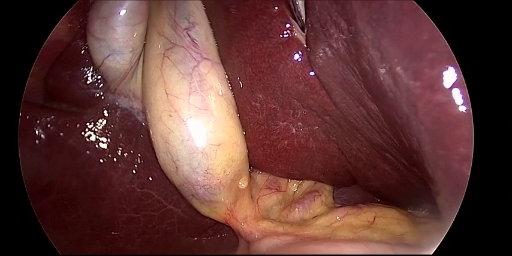

In [ ]:
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
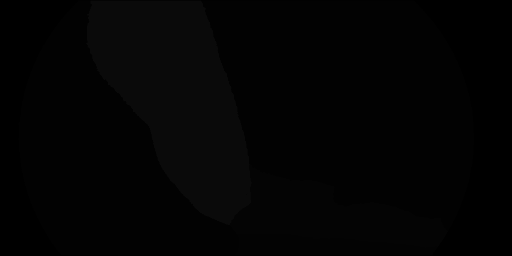

In [ ]:
img_gt

In [ ]:
img_gt.shape[2]

3

In [ ]:
for i in range(img_gt.shape[-1]):
  print(i)

0
1
2


In [ ]:
def obtener_valores_distintos(imagen):
    valores_distintos = np.unique(imagen)
    return valores_distintos

In [ ]:
print(obtener_valores_distintos(img_gt))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [ ]:
train_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/x')
train_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/train/y')

print('------------------------------------TRAINING INPUT------------------------------------')
print()
for file_path in train_x:
    file_name = os.path.basename(file_path)
    print(file_name, end= ': ')
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    print('CORRECT!')
print()
print('------------------------------------TRAINING GT------------------------------------')
print()
for file_path in train_y:
    file_name = os.path.basename(file_path)
    print(file_name, end= ': ')
    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)
    print('CORRECT!')

Se han truncado las últimas 5000 líneas del flujo de salida.
training_groundtruth-0261.png: CORRECT!
training_groundtruth-0262.png: CORRECT!
training_groundtruth-0264.png: CORRECT!
training_groundtruth-0265.png: CORRECT!
training_groundtruth-0266.png: CORRECT!
training_groundtruth-0268.png: CORRECT!
training_groundtruth-0269.png: CORRECT!
training_groundtruth-0270.png: CORRECT!
training_groundtruth-0272.png: CORRECT!
training_groundtruth-0274.png: CORRECT!
training_groundtruth-0277.png: CORRECT!
training_groundtruth-0280.png: CORRECT!
training_groundtruth-0281.png: CORRECT!
training_groundtruth-0283.png: CORRECT!
training_groundtruth-0286.png: CORRECT!
training_groundtruth-0287.png: CORRECT!
training_groundtruth-0288.png: CORRECT!
training_groundtruth-0289.png: CORRECT!
training_groundtruth-0290.png: CORRECT!
training_groundtruth-0291.png: CORRECT!
training_groundtruth-0292.png: CORRECT!
training_groundtruth-0293.png: CORRECT!
training_groundtruth-0294.png: CORRECT!
training_groundtrut

In [ ]:
test_x = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/x')
test_y = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/y')

archivos_erroneos = []
print('------------------------------------TEST INPUT------------------------------------')
print()
for file_path in test_x:
    file_name = os.path.basename(file_path)
    img = io.imread(file_path)
    if img.shape[-1] != 3:
      print(file_name,': ERROR!')
      print(img.shape)
      archivos_erroneos.append(file_path)

print()
print('------------------------------------TEST GT------------------------------------')
print()
for file_path in test_y:
    file_name = os.path.basename(file_path)
    img = io.imread(file_path)
    if img.shape[-1] != 3:
      print(file_name,': ERROR!')
      print(img.shape)
      archivos_erroneos.append(file_path)

print(archivos_erroneos)

------------------------------------TEST INPUT------------------------------------


------------------------------------TEST GT------------------------------------

testing_groundtruth-2637.png : ERROR!
(256, 512, 4)
testing_groundtruth-5438.png : ERROR!
(256, 512, 4)
testing_groundtruth-5857.png : ERROR!
(256, 512, 4)
['/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/y/testing_groundtruth-2637.png', '/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/y/testing_groundtruth-5438.png', '/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/y/testing_groundtruth-5857.png']


In [ ]:
for file_path in archivos_erroneos:
  img = io.imread(file_path)
  file_name = os.path.basename(file_path)
  img_tratada = img[:, :, :3]
  io.imsave(file_path, img_tratada, check_contrast=False)
  io.imsave(f'/content/drive/MyDrive/TFG/V2/evaluationV2/labelsTs/{file_name}', img_tratada, check_contrast=False)

In [ ]:
def load_and_covnert_case(input_seg):
    seg = io.imread(input_seg)
    seg[seg == 255] = 0
    seg[seg == 50] = 0
    seg[seg == 11] = 1
    seg[seg == 21] = 2
    seg[seg == 13] = 3
    seg[seg == 12] = 4
    seg[seg == 31] = 5
    seg[seg == 23] = 6
    seg[seg == 24] = 7
    seg[seg == 25] = 8
    seg[seg == 32] = 9
    seg[seg == 22] = 10
    seg[seg == 33] = 11
    seg[seg == 5] = 12
    io.imsave(input_seg, seg, check_contrast=False)

In [ ]:
labels = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/y', suffix='png')
for l in labels:
  load_and_covnert_case(l)

In [ ]:
for file_path in archivos_erroneos:

  img_tratada = io.imread(file_path)
  file_name = os.path.basename(file_path)
  img_tratada[img_tratada == 255] = 0
  io.imsave(file_path, img_tratada, check_contrast=False)
  io.imsave(f'/content/drive/MyDrive/TFG/V2/evaluationV2/labelsTs/{file_name}', img_tratada, check_contrast=False)

hola
hola
hola


In [ ]:
prueba = io.imread('/content/drive/MyDrive/TFG/V2/nnUNet_raw/Dataset212_CholecSeg8kV2/labelsTr/CS_0001.png')
prueba.shape

(480, 854, 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
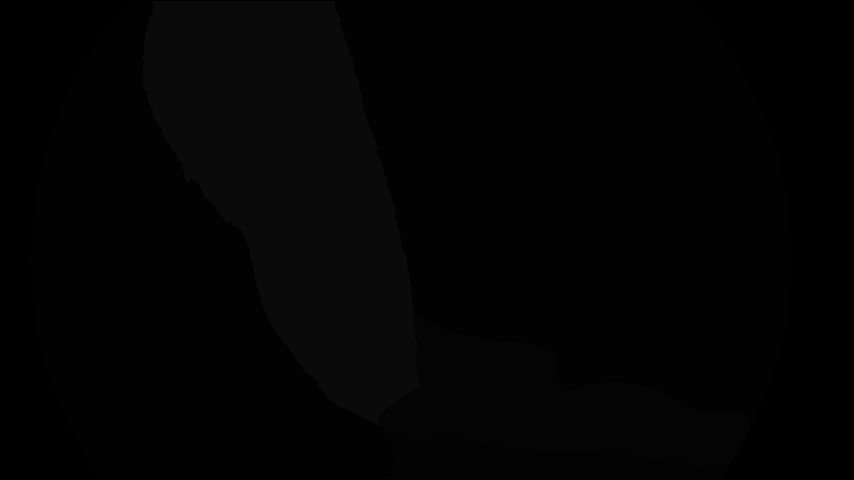

In [ ]:
prueba

In [ ]:
print(obtener_valores_distintos(prueba))

[ 0  2  3  4 10]


In [ ]:
nueva_imagen = cv2.resize(prueba, (512, 256), interpolation = cv2.INTER_NEAREST)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
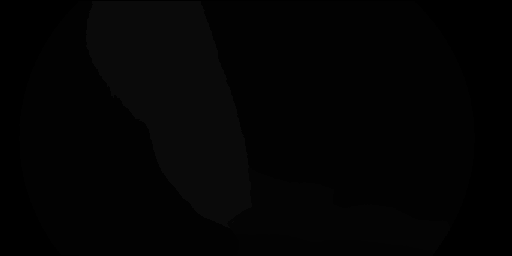

In [ ]:
nueva_imagen

In [ ]:
print(obtener_valores_distintos(nueva_imagen))

[ 0  2  3  4 10]


## Entrenamiento

In [ ]:
!python3 ./train/train_cholecseg8kV3.py --arch Uformer_T --batch_size 4 \
    --train_ps_a 192 --train_ps_b 384\
    --train_dir ./dataV3/CholecSeg8k/train  \
    --val_dir ./dataV3/CholecSeg8k/val --save_dir ./logs/ \
    --dataset CholecSeg8k --nepoch 250 --lr_initial 0.001 \
    --checkpoint 1 --val_ps_a 192 --val_ps_b 384\
    --segmentation --num_classes 13 --gpu 0 \
     --train_workers 6 --eval_workers 6 \
    --resume --pretrain_weights ./logs/CholecSeg8k/Uformer_T_/models/model_latest.pth

/content/drive/MyDrive/TFG/Uformer/V2/train
Namespace(batch_size=4, nepoch=250, train_workers=6, eval_workers=6, dataset='CholecSeg8k', pretrain_weights='./logs/CholecSeg8k/Uformer_T_/models/model_latest.pth', optimizer='adamw', lr_initial=0.001, step_lr=50, weight_decay=0.02, gpu='0', arch='Uformer_T', mode='denoising', dd_in=3, save_dir='./logs/', save_images=False, env='_', checkpoint=1, norm_layer='nn.LayerNorm', embed_dim=32, win_size=8, token_projection='linear', token_mlp='leff', att_se=False, modulator=False, vit_dim=256, vit_depth=12, vit_nheads=8, vit_mlp_dim=512, vit_patch_size=16, global_skip=False, local_skip=False, vit_share=False, train_ps_a=256, train_ps_b=512, val_ps_a=256, val_ps_b=512, resume=True, train_dir='./dataV3/CholecSeg8k/train', val_dir='./dataV3/CholecSeg8k/val', warmup=False, warmup_epochs=3, local_rank=-1, distribute=False, distribute_mode='DDP', segmentation=True, num_classes=13)
Now time is :  2024-03-21T21:11:03.007820
You choose Uformer_T...
/usr/loca

## Test

In [4]:
!python3 ./test/test_cholecseg8k.py --input_dir ./dataV3/CholecSeg8k/test \
  --result_dir ./logs/CholecSeg8k/Uformer_T_/results_no_color \
  --weights ./logs/CholecSeg8k/Uformer_T_/models/model_final.pth \
  --batch_size 4 --arch Uformer_T \
  --train_ps_a 256 --train_ps_b 512 \
  --segmentation --num_classes 13 --gpu 0

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
You choose Uformer_T...
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
===>Testing using weights:  ./logs/CholecSeg8k/Uformer_T_/models/model_final.pth
100% 404/404 [02:46<00:00,  2.42it/s]
Test Loss:  -0.7101907


## Postprocesado

In [ ]:
def colorear_seg_maps(seg_maps):
  seg2 = np.zeros((256, 512, 3))

  seg2[:, :, 0] = seg_maps
  seg2[:, :, 1] = seg_maps
  seg2[:, :, 2] = seg_maps

  pixeles_0 = np.all(seg2 == [0, 0, 0], axis=2)
  pixeles_1 = np.all(seg2 == [1, 1, 1], axis=2)
  pixeles_2 = np.all(seg2 == [2, 2, 2], axis=2)
  pixeles_3 = np.all(seg2 == [3, 3, 3], axis=2)
  pixeles_4 = np.all(seg2 == [4, 4, 4], axis=2)
  pixeles_5 = np.all(seg2 == [5, 5, 5], axis=2)
  pixeles_6 = np.all(seg2 == [6, 6, 6], axis=2)
  pixeles_7 = np.all(seg2 == [7, 7, 7], axis=2)
  pixeles_8 = np.all(seg2 == [8, 8, 8], axis=2)
  pixeles_9 = np.all(seg2 == [9, 9, 9], axis=2)
  pixeles_10 = np.all(seg2 == [10, 10, 10], axis=2)
  pixeles_11 = np.all(seg2 == [11, 11, 11], axis=2)
  pixeles_12 = np.all(seg2 == [12, 12, 12], axis=2)


  seg2[pixeles_0] = [127, 127, 127]
  seg2[pixeles_1] = [210, 140, 140]
  seg2[pixeles_2] = [255, 114, 114]
  seg2[pixeles_3] = [231, 70, 156]
  seg2[pixeles_4] = [186, 183, 75]
  seg2[pixeles_5] = [170, 255, 0]
  seg2[pixeles_6] = [255, 85, 0]
  seg2[pixeles_7] = [255, 0, 0]
  seg2[pixeles_8] = [255, 255, 0]
  seg2[pixeles_9] = [169, 255, 184]
  seg2[pixeles_10] = [255, 160, 165]
  seg2[pixeles_11] = [0, 50, 128]
  seg2[pixeles_12] = [111, 74, 0]

  return seg2

In [ ]:
test_predictions = subfiles('/content/drive/MyDrive/TFG/Uformer/V2/logs/CholecSeg8k/Uformer_T_/results/png')

for file_path in test_predictions:
    file_name = os.path.basename(file_path)
    imagen = io.imread(file_path)
    nueva_imagen = colorear_seg_maps(imagen)
    nueva_imagen = nueva_imagen.astype(np.uint8)
    nueva_imagen = cv2.resize(nueva_imagen, (854, 480), interpolation = cv2.INTER_NEAREST)
    nueva_imagen = nueva_imagen.astype(np.uint8)
    #io.imshow(nueva_imagen)
    io.imsave(file_path, nueva_imagen, check_contrast=False)

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:304: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


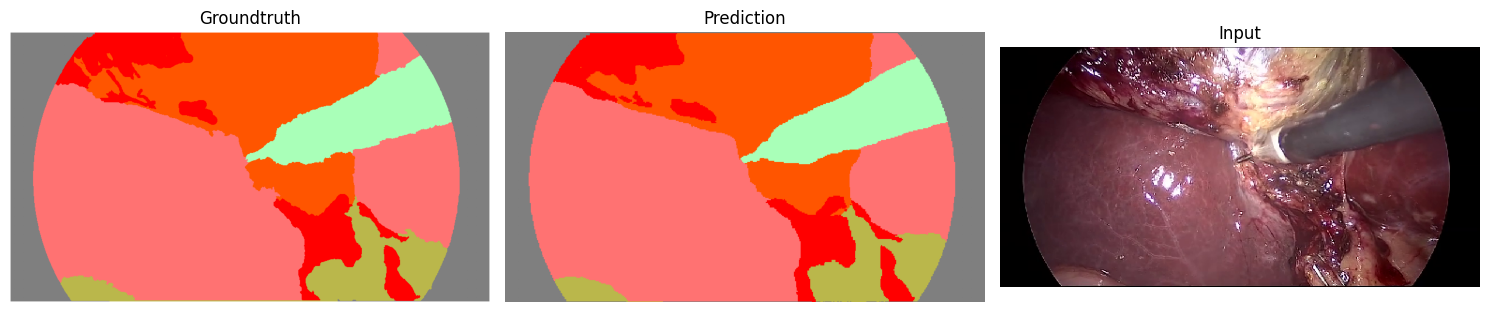

In [ ]:
import matplotlib.pyplot as plt
import os

directorios = {'groundtruth': '/content',
               'prediction': '/content/drive/MyDrive/TFG/Uformer/V2/logs/CholecSeg8k/Uformer_T_/results/png',
               'input': '/content/drive/MyDrive/TFG/Uformer/V2/dataV3/CholecSeg8k/test/x'}

nombres_imagenes = {'groundtruth': 'CS_1034.png',
                    'prediction': 'test_prediction-1034.png',
                    'input': 'testing-1034.png'}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (tipo, directorio) in enumerate(directorios.items()):
    imagen_path = os.path.join(directorio, nombres_imagenes[tipo])

    imagen = plt.imread(imagen_path)
    axs[i].imshow(imagen)
    axs[i].set_title(tipo.capitalize())
    axs[i].axis('off')

plt.tight_layout()
plt.show()